# Inventory Monitoring at Distribution Centers

Distribution centers often use robots to move objects as a part of their operations. Objects are carried in bins which can contain multiple objects.
In this project, you will have to build a model that can count the number of objects in each bin. A system like this can be used to track inventory and make sure that delivery consignments have the correct number of items.


The notebook is used to build a model that can count or classify the number of objects in each bin into one of 5 classes; class 1, class 2, class 3, class 4 and class 5. The tasks involved are:

1-	Download and process a subset of Amazon Bin Image Dataset and upload it to S3 bucket.

2-	Train the model using AWS sagemaker.

3-	Fine tune the model to improve its performance by using the extracted best hyperparameters of hyperparameters tuning.

4-	Perform a prediction on the model.


**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [3]:
# TODO: Install any packages that you might need
!pip install smdebug
!pip install jinja2==3.0
!pip install torchvision

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
  Using cached Jinja2-3.0.0-py3-none-any.whl (133 kB)
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.1.2
    Uninstalling Jinja2-3.1.2:
      Successfully uninstalled Jinja2-3.1.2

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
  Using cached torchvision-0.14.1-cp37-cp37m-manylinux1_x86_64.whl (24.2 MB)
  Using cached torch-1.13.1-cp37-cp37m-manylinux1_x86_64.whl (887.5 MB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl (849 kB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-

In [4]:
# TODO: Import any packages that you might need
import sagemaker
from sagemaker import get_execution_role
from sagemaker.tuner import (IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner)
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig
import boto3

role= sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
region = boto3.session.Session().region_name


## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [4]:
from tqdm import tqdm
import os
import json
import boto3

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name), os.path.join(directory, file_name))
download_and_arrange_data()

  0%|          | 1/1228 [00:00<03:25,  5.96it/s]

  0%|          | 1/2299 [00:00<07:02,  5.44it/s]

  0%|          | 2/2666 [00:00<02:54, 15.25it/s]

  0%|          | 1/2373 [00:00<05:00,  7.89it/s]

  0%|          | 1/1875 [00:00<04:38,  6.73it/s]

100%|██████████| 1875/1875 [03:15<00:00,  9.59it/s]


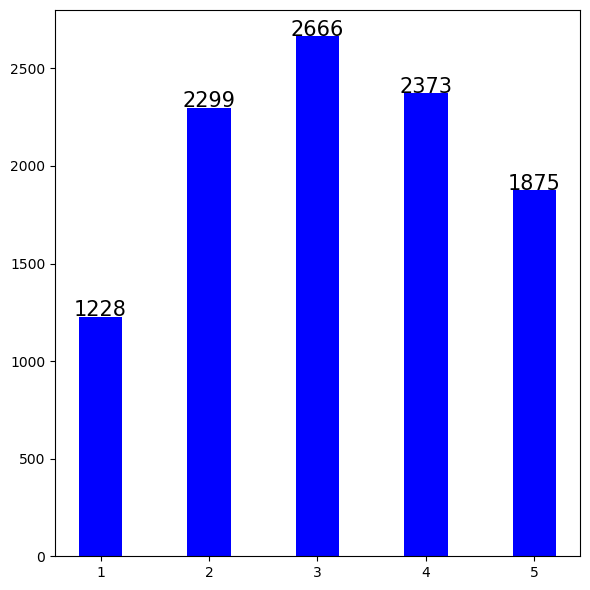

'\n# Iterrating over the bars one-by-one\nfor bar in ax.patches:\n   \n    ax.annotate(format(bar.get_height(), \'.2f\'),\n                   (bar.get_x() + bar.get_width() / 2,\n                    bar.get_height()), ha=\'center\', va=\'center\',\n                   size=15, xytext=(0, 8),\n                   textcoords=\'offset points\')\nplt.xlabel("object class")\nplt.ylabel("Data")\n\nplt.show()\n'

In [28]:
#visualize dataset
import numpy as np
import matplotlib.pyplot as plt
import json

with open('file_list.json', 'r') as f:
        d=json.load(f)
        
object_class = [(k) for k in d.keys()]
values = [len(v) for v in d.values()]
  
fig, ax =  plt.subplots(figsize = (6, 6))
 
# creating the bar plot
ax.bar(object_class, values, color ='blue',width = 0.4)

for index,data in enumerate(values):
    plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=15), ha='center')
plt.tight_layout()
plt.show()


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [7]:
#TODO: Perform any data cleaning or data preprocessing
import os
import numpy as np
import shutil
import random

data_dir = 'train_data/'  # data path
classes_dir = ['1', '2', '3', '4', '5']   #total classes

#split pecentage 0.8, 0.05 and 0.15 for train, valid and test respectively
valid_ratio = 0.05
test_ratio = 0.15

#create new directories for data
for cls in classes_dir:
    os.makedirs(data_dir +'train/' + cls)
    os.makedirs(data_dir +'valid/' + cls)
    os.makedirs(data_dir +'test/' + cls)

#apply randomly split percentage and copy images to it's new directory
#class 1
src = data_dir +'1/'  # directory class 1 images 
all_class1 = os.listdir("train_data/1/")
#randomly shuffle images
np.random.shuffle(all_class1)  
train_FileNames, valid_FileNames, test_FileNames = np.split(np.array(all_class1),
                                                          [int(len(all_class1)* (1 - (valid_ratio + test_ratio))), 
                                                           int(len(all_class1)* (1 - test_ratio))])

#clear data from ".ipynb_checkpoints" where it's not an object image
indices = np.where(train_FileNames==".ipynb_checkpoints")
train_FileNames = np.delete(train_FileNames, indices)
indices = np.where(valid_FileNames==".ipynb_checkpoints")
valid_FileNames = np.delete(valid_FileNames, indices)
indices = np.where(test_FileNames==".ipynb_checkpoints")
test_FileNames = np.delete(test_FileNames, indices)

#copy images to it's new directory   
for name in train_FileNames:
    shutil.copy(src + name, data_dir +'train/1/'+ name)
for name in valid_FileNames:
    shutil.copy(src + name, data_dir +'valid/1/'+ name)
for name in test_FileNames:
    shutil.copy(src + name, data_dir +'test/1/' + name)
    
# class 2  
src = data_dir +'2/' # directory class 2 images 
all_class2 = os.listdir("train_data/2/")
#randomly shuffle images
np.random.shuffle(all_class2)
train_FileNames2, valid_FileNames2, test_FileNames2 = np.split(np.array(all_class2),
                                                          [int(len(all_class2)* (1 - (valid_ratio + test_ratio))), 
                                                           int(len(all_class2)* (1 - test_ratio))])

#clear data from ".ipynb_checkpoints" where it's not an object image
indices = np.where(train_FileNames2==".ipynb_checkpoints")
train_FileNames2 = np.delete(train_FileNames2, indices)
indices = np.where(valid_FileNames2==".ipynb_checkpoints")
valid_FileNames2 = np.delete(valid_FileNames2, indices)
indices = np.where(test_FileNames2==".ipynb_checkpoints")
test_FileNames2 = np.delete(test_FileNames2, indices)

#copy images to it's new directory     
for name in train_FileNames2:
    shutil.copy(src + name, data_dir +'train/2/'+ name)
for name in valid_FileNames2:
    shutil.copy(src + name, data_dir +'valid/2/'+ name)
for name in test_FileNames2:
    shutil.copy(src + name, data_dir +'test/2/' + name)
    
### class 3
src = data_dir +'3/' # directory class 3 images 
all_class3 = os.listdir("train_data/3/")
#randomly shuffle images
np.random.shuffle(all_class3)
train_FileNames, valid_FileNames, test_FileNames = np.split(np.array(all_class3),
                                                          [int(len(all_class3)* (1 - (valid_ratio + test_ratio))), 
                                                           int(len(all_class3)* (1 - test_ratio))])

#clear data from ".ipynb_checkpoints" where it's not an object image
indices = np.where(train_FileNames==".ipynb_checkpoints")
train_FileNames = np.delete(train_FileNames, indices)
indices = np.where(valid_FileNames==".ipynb_checkpoints")
valid_FileNames = np.delete(valid_FileNames, indices)
indices = np.where(test_FileNames==".ipynb_checkpoints")
test_FileNames = np.delete(test_FileNames, indices)

#copy images to it's new directory
for name in train_FileNames:
    shutil.copy(src + name, data_dir +'train/3/'+ name)
for name in valid_FileNames:
    shutil.copy(src + name, data_dir +'valid/3/'+ name)
for name in test_FileNames:
    shutil.copy(src + name, data_dir +'test/3/' + name)
    
### class 4
src = data_dir +'4/' # directory class 4 images 
all_class4 = os.listdir("train_data/4/")
#randomly shuffle images
np.random.shuffle(all_class4)
train_FileNames, valid_FileNames, test_FileNames = np.split(np.array(all_class4),
                                                          [int(len(all_class4)* (1 - (valid_ratio + test_ratio))), 
                                                           int(len(all_class4)* (1 - test_ratio))])

#clear data from ".ipynb_checkpoints" where it's not an object image
indices = np.where(train_FileNames==".ipynb_checkpoints")
train_FileNames = np.delete(train_FileNames, indices)
indices = np.where(valid_FileNames==".ipynb_checkpoints")
valid_FileNames = np.delete(valid_FileNames, indices)
indices = np.where(test_FileNames==".ipynb_checkpoints")
test_FileNames = np.delete(test_FileNames, indices)

#copy images to it's new directory    
for name in train_FileNames:
    shutil.copy(src + name, data_dir +'train/4/'+ name)
for name in valid_FileNames:
    shutil.copy(src + name, data_dir +'valid/4/'+ name)
for name in test_FileNames:
    shutil.copy(src + name, data_dir +'test/4/' + name)
    
### class 5
src = data_dir +'5/' # directory class 5 images 
all_class5 = os.listdir("train_data/5/") 
#randomly shuffle images
np.random.shuffle(all_class5)
train_FileNames, valid_FileNames, test_FileNames = np.split(np.array(all_class5),
                                                          [int(len(all_class5)* (1 - (valid_ratio + test_ratio))), 
                                                           int(len(all_class5)* (1 - test_ratio))])

#clear data from ".ipynb_checkpoints" where it's not an object image   
indices = np.where(train_FileNames==".ipynb_checkpoints")
train_FileNames = np.delete(train_FileNames, indices)
indices = np.where(valid_FileNames==".ipynb_checkpoints")
valid_FileNames = np.delete(valid_FileNames, indices)
indices = np.where(test_FileNames==".ipynb_checkpoints")
test_FileNames = np.delete(test_FileNames, indices)

#copy images to it's new directory    
for name in train_FileNames:
    shutil.copy(src + name, data_dir +'train/5/'+ name)
for name in valid_FileNames:
    shutil.copy(src + name, data_dir +'valid/5/'+ name)
for name in test_FileNames:
    shutil.copy(src + name, data_dir +'test/5/' + name)

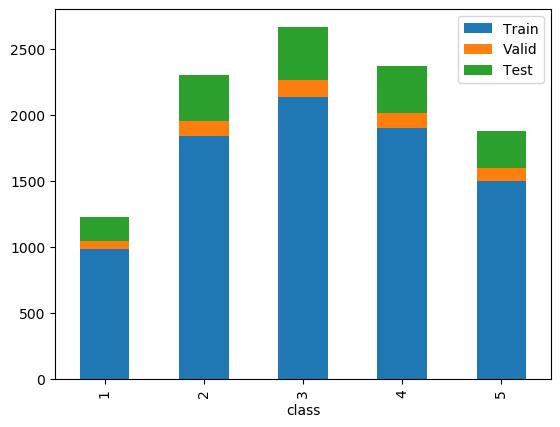

In [5]:
# visualize divided dataset into train, valid and test dataset per class
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

with open('file_list.json', 'r') as f:
        d=json.load(f)
        
object_class = [(k) for k in d.keys()]
values = [len(v) for v in d.values()]
classes = [1,2,3,4,5]
train = [0.8*len(v) for v in d.values()]
valid = [0.05*len(v) for v in d.values()]
test = [0.15*len(v) for v in d.values()]

df = pd.DataFrame(data=zip(classes,train,valid,test),columns=['class','Train','Valid','Test'])
df.plot.bar(x="class" ,stacked=True)
plt.show()

In [7]:
#TODO: Upload the data to AWS S3

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync train_data/train/ s3://${DEFAULT_S3_BUCKET}/train_data/train/
!aws s3 sync train_data/valid/ s3://${DEFAULT_S3_BUCKET}/train_data/valid/
!aws s3 sync train_data/test/ s3://${DEFAULT_S3_BUCKET}/train_data/test/


upload: train_data/train/1/.ipynb_checkpoints/105266-checkpoint.jpg to s3://sagemaker-us-east-1-027003389477/train_data/train/1/.ipynb_checkpoints/105266-checkpoint.jpg
upload: train_data/train/1/00035.jpg to s3://sagemaker-us-east-1-027003389477/train_data/train/1/00035.jpg
upload: train_data/train/1/.ipynb_checkpoints/105189-checkpoint.jpg to s3://sagemaker-us-east-1-027003389477/train_data/train/1/.ipynb_checkpoints/105189-checkpoint.jpg
upload: train_data/train/1/00086.jpg to s3://sagemaker-us-east-1-027003389477/train_data/train/1/00086.jpg
upload: train_data/train/1/00024.jpg to s3://sagemaker-us-east-1-027003389477/train_data/train/1/00024.jpg
upload: train_data/train/1/00009.jpg to s3://sagemaker-us-east-1-027003389477/train_data/train/1/00009.jpg
upload: train_data/train/1/.ipynb_checkpoints/105269-checkpoint.jpg to s3://sagemaker-us-east-1-027003389477/train_data/train/1/.ipynb_checkpoints/105269-checkpoint.jpg
upload: train_data/train/1/00084.jpg to s3://sagemaker-us-east-1-

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [6]:
import os
os.environ['SM_CHANNEL_TRAINING']='s3://sagemaker-us-east-1-027003389477/train_data/'
os.environ['SM_MODEL_DIR']='s3://sagemaker-us-east-1-027003389477/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://sagemaker-us-east-1-027003389477/output/'

inputs="s3://sagemaker-us-east-1-027003389477/train_data/"

In [10]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values
hyperparameters = {"batch-size":"64" , 
                   "epochs":"4",
                   "lr":'0.001' }

In [12]:
#TODO: Create your training estimator
estimator = PyTorch(entry_point="train.py", 
                    base_job_name='',
                    role = role,
                    instance_count=1,
                    instance_type= "ml.m5.xlarge",
                    hyperparameters = hyperparameters,
                    framework_version="1.8",
                    py_version="py36")


In [13]:
# TODO: Fit your estimator
estimator.fit({"training":inputs})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-04-18-22-05-52-640


2023-04-18 22:05:53 Starting - Starting the training job...
2023-04-18 22:06:22 Starting - Preparing the instances for training......
2023-04-18 22:07:06 Downloading - Downloading input data...
2023-04-18 22:07:41 Training - Downloading the training image...
2023-04-18 22:08:17 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-18 22:08:23,693 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-18 22:08:23,696 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-18 22:08:23,705 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-18 22:08:23,707 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-18 22:08:23,879 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [16]:
#TODO: Create your hyperparameter search space
hyperparameter_ranges= {"lr": ContinuousParameter(0.001, 0.1),
                        "epochs":IntegerParameter(1,5),
                        "batch-size":CategoricalParameter([32, 64, 128, 256, 512])}

objective_metric_name= "Test Loss"
objective_type= "Minimize"
metric_definition= [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [18]:
#TODO: Create your training estimator
estimator = PyTorch(entry_point = "train.py",
                                    role= role,
                                    py_version="py36",
                                    framework_version="1.8",
                                    instance_count=1,
                                    instance_type="ml.m5.xlarge"
)

# TODO: Your estimator here

tuner = HyperparameterTuner(
        estimator,
        objective_metric_name,
        hyperparameter_ranges,
        metric_definition,
        max_jobs=6,
        max_parallel_jobs=2,
        objective_type= objective_type
)

In [19]:
# TODO: Fit your estimator
tuner.fit({"training":inputs})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230418-2232


..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [26]:
# describe tuning results
from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-230418-2232')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)


batch-size  epochs        lr                            TrainingJobName  \
4      "512"     3.0  0.023112  pytorch-training-230418-2232-002-bc356f4c   
5      "256"     5.0  0.094644  pytorch-training-230418-2232-001-b324ef1d   
3       "32"     4.0  0.043366  pytorch-training-230418-2232-003-2bd30238   
2      "256"     2.0  0.001694  pytorch-training-230418-2232-004-5d150e2e   
0      "128"     5.0  0.001349  pytorch-training-230418-2232-006-8f0e77fc   
1       "32"     2.0  0.005483  pytorch-training-230418-2232-005-2da65eaa   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
4         Completed             1.597603 2023-04-18 22:33:46+00:00   
5         Completed             1.581122 2023-04-18 22:33:36+00:00   
3         Completed             1.579207 2023-04-18 23:02:14+00:00   
2         Completed             1.538173 2023-04-18 23:02:17+00:00   
0         Completed             1.527013 2023-04-18 23:27:00+00:00   
1         Completed             1.508206 2023-04-18 23:26:58+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
4 2023-04-18 22:58:08+00:00                      1462.0  
5 2023-04-18 22:57:54+00:00                      1458.0  
3 2023-04-18 23:22:51+00:00                      1237.0  
2 2023-04-18 23:25:40+00:00                      1403.0  
0 2023-04-18 23:49:57+00:00                      1377.0  
1 2023-04-18 23:47:35+00:00                      1237.0

In [23]:
# TODO: Find the best hyperparameters
#the best estimator

best_estimator = tuner.best_estimator()


#the best hyperparameters of the best trained model
HP_best_trained = best_estimator.hyperparameters()


2023-04-18 23:47:37 Starting - Found matching resource for reuse
2023-04-18 23:47:37 Downloading - Downloading input data
2023-04-18 23:47:37 Training - Training image download completed. Training in progress.
2023-04-18 23:47:37 Uploading - Uploading generated training model
2023-04-18 23:47:37 Completed - Resource retained for reuse


In [27]:
hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')), \
                   "epochs":best_estimator.hyperparameters()['epochs'], "lr": best_estimator.hyperparameters()['lr']}
hyperparameters

{'batch-size': 32, 'epochs': '2', 'lr': '0.005482862483508994'}

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [17]:
hyperparameters = {"batch-size":"32" , 
                   "epochs":"2",
                   "lr":'0.005482862483508994' }

In [19]:
# TODO: Set up debugging and profiling rules and hooks
rules = [ Rule.sagemaker(rule_configs.vanishing_gradient()),
               Rule.sagemaker(rule_configs.overfit()),
               Rule.sagemaker(rule_configs.overtraining()),
               Rule.sagemaker(rule_configs.poor_weight_initialization()),
               Rule.sagemaker(rule_configs.loss_not_decreasing()),
               ProfilerRule.sagemaker(rule_configs.ProfilerReport()) ]




collection_configs = [
    CollectionConfig(
        name="custom_losses",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "100",
            "eval.save_interval": "10"
        }
    )
]

profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params = FrameworkProfile(num_steps=10))
debugger_config = DebuggerHookConfig(collection_configs = collection_configs)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [20]:
# TODO: Create and fit an estimator
estimator = PyTorch(entry_point="debug_model.py", 
                                    role = role,
                                    instance_count=1,
                                    instance_type= "ml.m5.xlarge",
                                    hyperparameters = hyperparameters,
                                    framework_version="1.8",
                                    py_version="py36",
                                    rules= rules,
                                    profiler_config= profiler_config,
                                    debugger_hook_config= debugger_config)

estimator.fit({"training":inputs})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-04-19-02-44-46-350


2023-04-19 02:44:56 Starting - Starting the training job...
2023-04-19 02:45:25 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
ProfilerReport: InProgress
...
2023-04-19 02:45:56 Downloading - Downloading input data......
2023-04-19 02:46:46 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-19 02:47:09,396 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-19 02:47:09,398 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-19 02:47:09,407 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-19 02:47:09,409 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-19 02:47:09,581 sa

[2023-04-19 03:08:13.401 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:18 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-04-19 03:08:13.426 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-027003389477/pytorch-training-2023-04-19-02-44-46-350/debug-output
[2023-04-19 03:08:14.031 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-04-19 03:08:15.047 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:18 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input

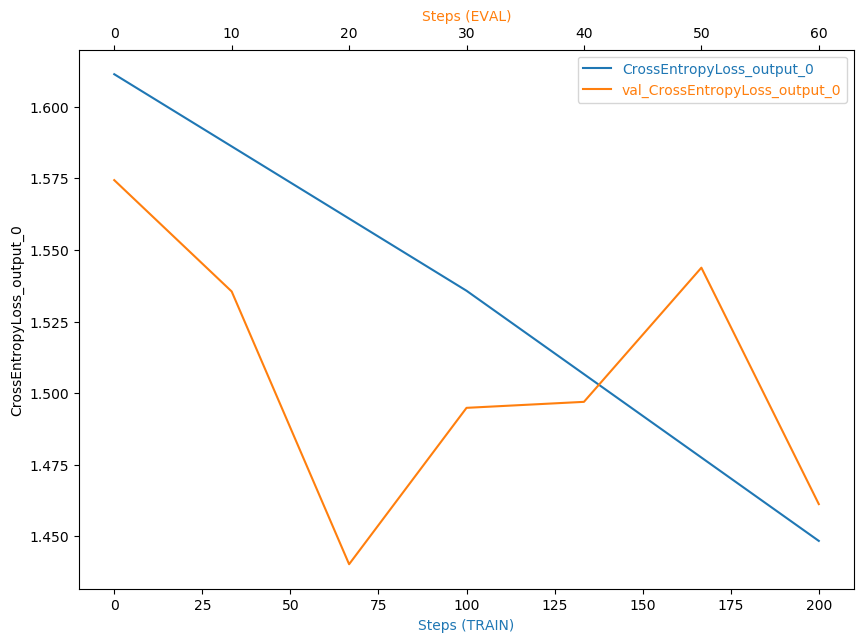

In [21]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
describtion = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

#Set up functions to plot the output tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [22]:

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
! aws s3 ls {rule_output_path} --recursive

2023-04-19 03:07:42     386270 pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-04-19 03:07:42     236294 pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-04-19 03:07:38        192 pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-04-19 03:07:38        200 pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-04-19 03:07:38       1988 pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-04-19 03:07:38        127 pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-04-19 03:07:38        199 pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-re

In [23]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-027003389477/pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-027003389477/pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-027003389477/pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-027003389477/pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-027003389477/pytorch-training-2023-

In [25]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [26]:
# TODO: Display the profiler output
from jinja2.utils import markupsafe 
from markupsafe import Markup
session = boto3.session.Session()
region = session.region_name
training_job_name = estimator.latest_training_job.name
print(f"training jobname:{training_job_name}")
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

training jobname:pytorch-training-2023-04-19-02-44-46-350


ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-027003389477/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-027003389477/pytorch-training-2023-04-19-02-44-46-350/profiler-output


Profiler data from system is available


[2023-04-19 03:08:47.833 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:18 INFO metrics_reader_base.py:134] Getting 23 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


In [27]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-027003389477/pytorch-training-2023-04-19-02-44-46-350/rule-output


In [28]:
! aws s3 ls {rule_output_path} --recursive

2023-04-19 03:07:42     386270 pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-04-19 03:07:42     236294 pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-04-19 03:07:38        192 pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-04-19 03:07:38        200 pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-04-19 03:07:38       1988 pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-04-19 03:07:38        127 pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-04-19 03:07:38        199 pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-re

In [29]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-027003389477/pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-027003389477/pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-027003389477/pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-027003389477/pytorch-training-2023-04-19-02-44-46-350/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-027003389477/pytorch-training-2023-04-19-02-44-46-350/rul

In [30]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [31]:
# retrain train.py using best hyperparameters
hyperparameters = {"batch-size":"32" , 
                   "epochs":"2",
                   "lr":'0.005482862483508994'}
#create estimator
estimator = PyTorch(entry_point="train.py", 
                    base_job_name='',
                    role = role,
                    instance_count=1,
                    instance_type= "ml.m5.xlarge",
                    hyperparameters = hyperparameters,
                    framework_version="1.8",
                    py_version="py36")

#fit estimator
estimator.fit({"training":inputs})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-04-19-03-10-51-250


2023-04-19 03:10:52 Starting - Starting the training job...
2023-04-19 03:11:07 Starting - Preparing the instances for training...
2023-04-19 03:11:51 Downloading - Downloading input data...
2023-04-19 03:12:26 Training - Downloading the training image...
2023-04-19 03:12:57 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-19 03:13:03,901 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-19 03:13:03,904 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-19 03:13:03,912 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-19 03:13:03,914 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-19 03:13:04,069 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2

In [33]:
# TODO: Deploy your model to an endpoint
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [35]:
model_location=estimator.model_data
print(model_location)

s3://sagemaker-us-east-1-027003389477/pytorch-training-2023-04-19-03-10-51-250/output/model.tar.gz


In [83]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [84]:
pytorch_model = PyTorchModel(model_data="s3://sagemaker-us-east-1-027003389477/pytorch-training-2023-04-19-03-10-51-250/output/model.tar.gz", role=role, entry_point='infernce.py',py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [85]:
# TODO: Deploy your model to an endpoint

predictor=pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker:Creating model with name: pytorch-inference-2023-04-19-04-58-19-773
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-04-19-04-58-20-532
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-04-19-04-58-20-532


-----!

2


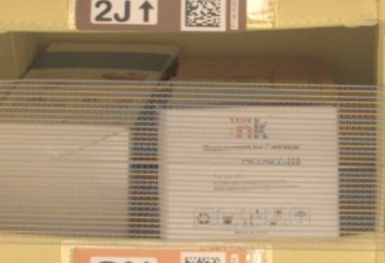

In [43]:
from PIL import Image

image ='train_data/test/2/00063.jpg'
target_str = 'test/'
img_num= image.index(target_str) + len(target_str)
label = int(image[img_num])
print(label)
#Displaying image to be predicted
img = Image.open(image)   
display(img)
          

In [44]:
image_bytes = open(image, 'rb').read()
response = predictor.predict(image_bytes, initial_args={'ContentType':'image/jpeg'})
response[0]

[0.11023664474487305,
 0.708800196647644,
 0.5249566435813904,
 0.3053041100502014,
 -0.4714588522911072]

In [46]:
import numpy as np
prediction = np.argmax(response[0]) + 1 
prediction

2

PREDICTION CLASS IS:4,   OBJECT CLASS IS: 5


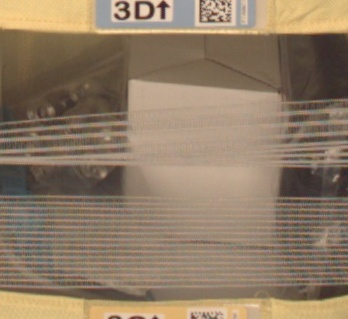



PREDICTION CLASS IS:1,   OBJECT CLASS IS: 1


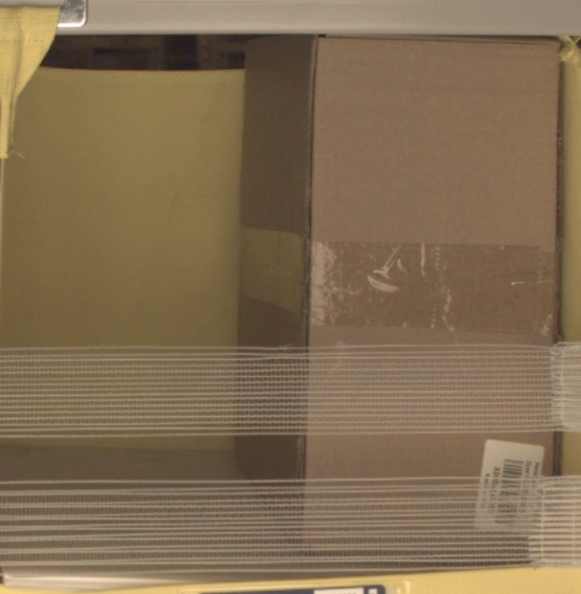



PREDICTION CLASS IS:4,   OBJECT CLASS IS: 3


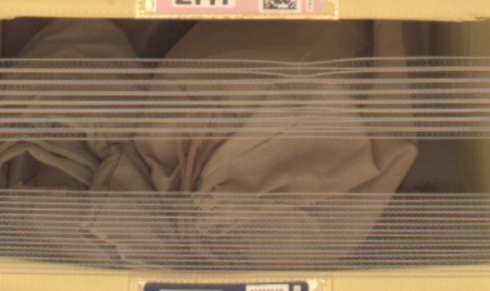



PREDICTION CLASS IS:1,   OBJECT CLASS IS: 1


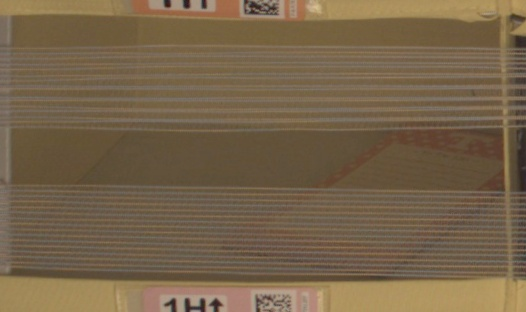



PREDICTION CLASS IS:4,   OBJECT CLASS IS: 4


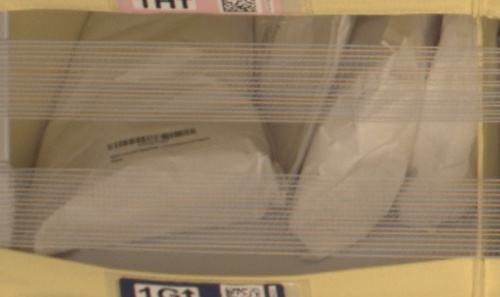



PREDICTION CLASS IS:2,   OBJECT CLASS IS: 1


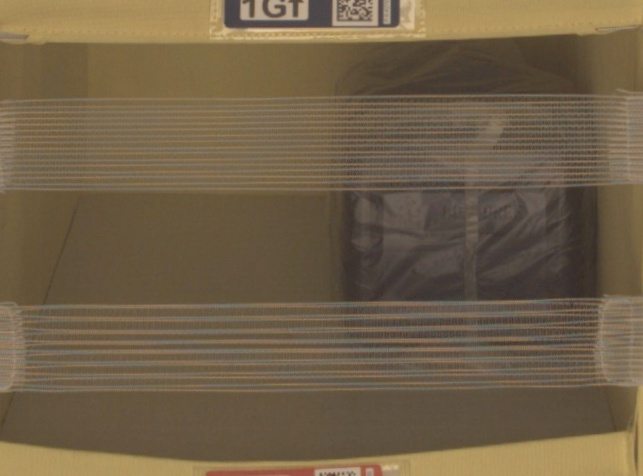



PREDICTION CLASS IS:4,   OBJECT CLASS IS: 5


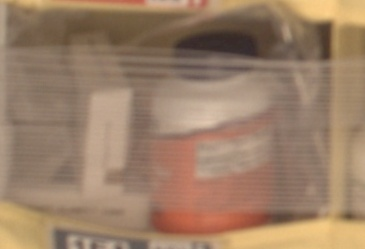



PREDICTION CLASS IS:1,   OBJECT CLASS IS: 1


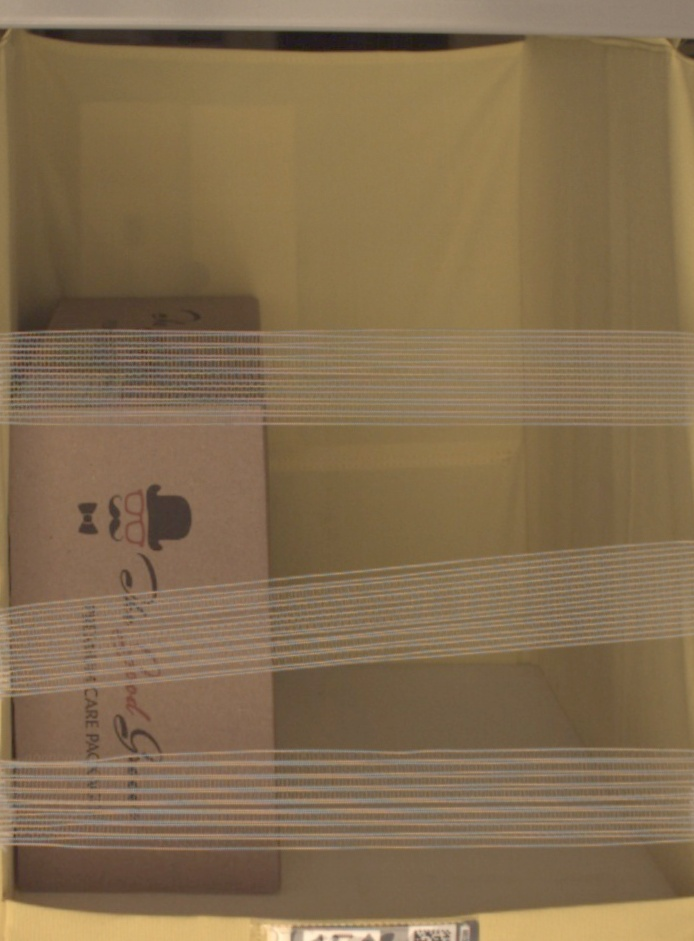



PREDICTION CLASS IS:2,   OBJECT CLASS IS: 3


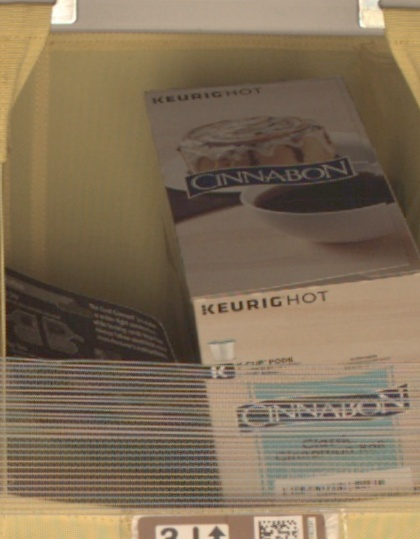



PREDICTION CLASS IS:1,   OBJECT CLASS IS: 2


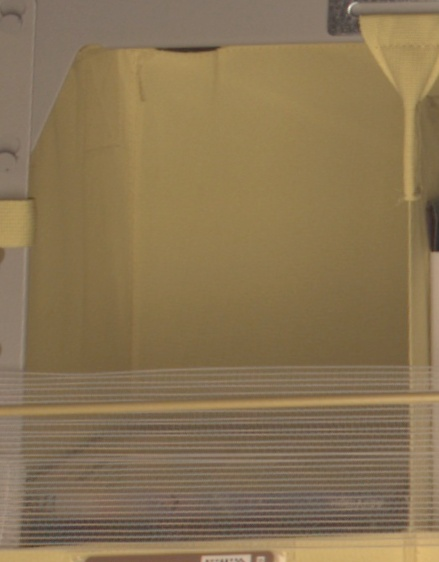



PREDICTION CLASS IS:3,   OBJECT CLASS IS: 4


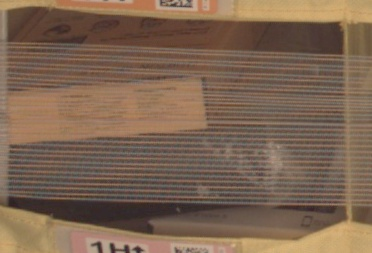



PREDICTION CLASS IS:2,   OBJECT CLASS IS: 2


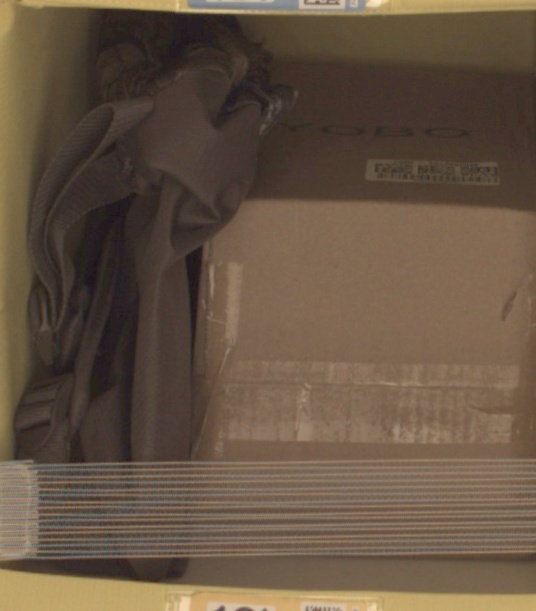



PREDICTION CLASS IS:3,   OBJECT CLASS IS: 4


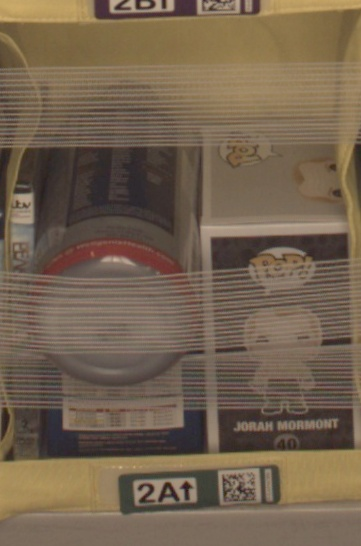



PREDICTION CLASS IS:4,   OBJECT CLASS IS: 5


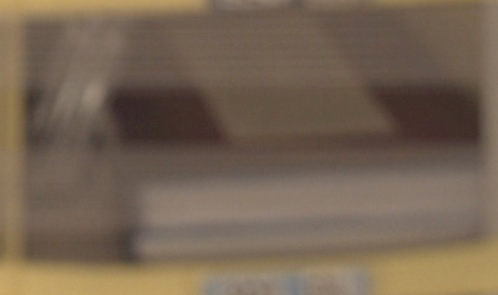



PREDICTION CLASS IS:3,   OBJECT CLASS IS: 2


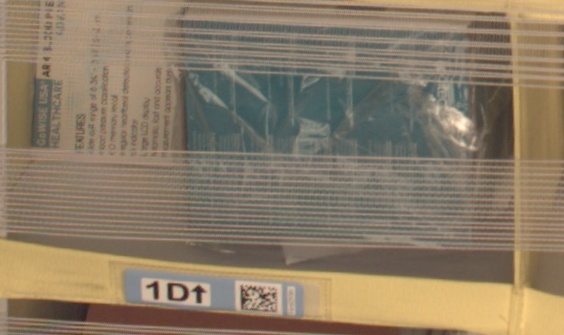



PREDICTION CLASS IS:3,   OBJECT CLASS IS: 3


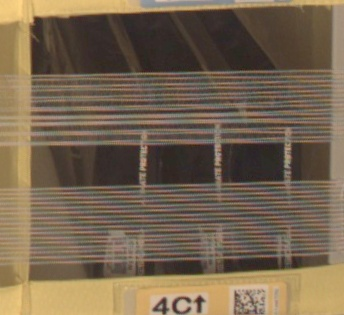



PREDICTION CLASS IS:3,   OBJECT CLASS IS: 3


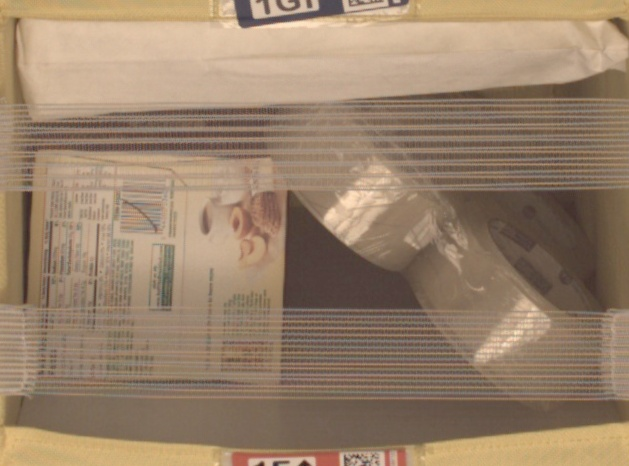



PREDICTION CLASS IS:3,   OBJECT CLASS IS: 2


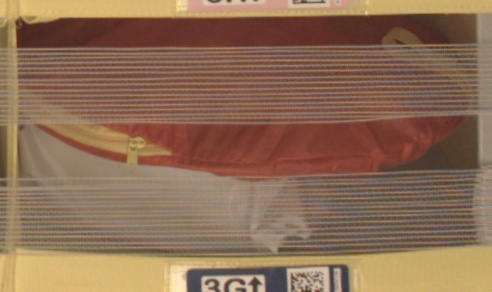



PREDICTION CLASS IS:4,   OBJECT CLASS IS: 5


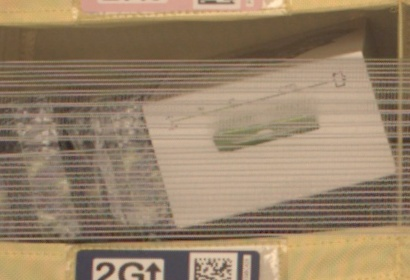



PREDICTION CLASS IS:4,   OBJECT CLASS IS: 4


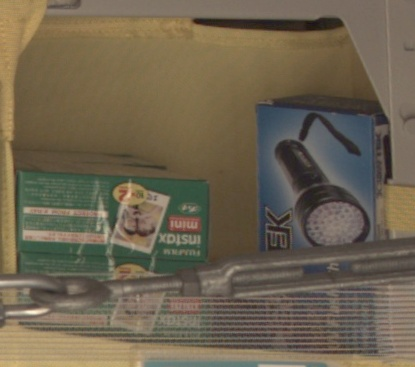

In [62]:
# TODO: Run an prediction on the endpoint
from PIL import Image

images = ['train_data/test/5/00182.jpg',
          'train_data/test/1/00418.jpg',
          'train_data/test/3/00098.jpg',
          'train_data/test/1/06552.jpg',
          'train_data/test/4/00007.jpg',
          'train_data/test/1/100653.jpg',
          'train_data/test/5/101229.jpg',
          'train_data/test/1/10506.jpg',
          'train_data/test/3/05381.jpg',
          'train_data/test/2/00651.jpg',
          'train_data/test/4/00848.jpg',
          'train_data/test/2/07690.jpg',
          'train_data/test/4/103797.jpg',
          'train_data/test/5/102825.jpg',
          'train_data/test/2/101399.jpg',
          'train_data/test/3/08377.jpg',
          'train_data/test/3/105220.jpg',
          'train_data/test/2/103891.jpg',
          'train_data/test/5/104134.jpg',
          'train_data/test/4/07147.jpg',
         ]
for image in images:
    target_str = 'test/'
    img_num= image.index(target_str) + len(target_str)
    label = int(image[img_num])
    # Displaying image to be predicted
    img = Image.open(image)
    image_bytes = open(image, 'rb').read()
    response = predictor.predict(image_bytes, initial_args={'ContentType':'image/jpeg'})
    prediction = np.argmax(response[0]) + 1 
   
    print("PREDICTION CLASS IS:{},   OBJECT CLASS IS: {}".format(prediction, label))
    #print('The object class is: {}'.format(label))
    display(img)
    print(   "\n")
    

  

In [63]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-04-19-03-37-19-264
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-04-19-03-37-19-264


### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis


In [10]:
# TODO: Train your model using a spot instance
import uuid

# create a unique checkpoint id name for chekpoint s3 path 
checkpoint_suffix = str(uuid.uuid4())[:8]
checkpoint_s3_path = 's3://{}/checkpoint-{}'.format(bucket, checkpoint_suffix)

#set spot instance consructor arguments
use_spot_instances = True
max_run=600
max_wait = 1200 if use_spot_instances else None


hyperparameters = {"batch-size":"32" , 
                   "epochs":"2",
                   "lr":'0.005482862483508994'}

#spot estimator
spot_instance_estimator = PyTorch(entry_point='train.py',
                            role=role,
                            framework_version='1.8',
                            py_version='py36',
                            instance_count=1,
                            instance_type='ml.m5.large',
                            base_job_name='spot-instance-trainingjob',
                            hyperparameters=hyperparameters,
                            checkpoint_s3_uri=checkpoint_s3_path,
                            debugger_hook_config=False,
                            use_spot_instances=use_spot_instances,
                            max_run=max_run,
                            max_wait=max_wait)

spot_instance_estimator.fit(inputs)


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: spot-instance-trainingjob-2023-04-19-06-27-50-075


2023-04-19 06:27:58 Starting - Starting the training job...
2023-04-19 06:28:13 Starting - Preparing the instances for training.........
2023-04-19 06:29:39 Downloading - Downloading input data......
2023-04-19 06:30:55 Training - Downloading the training image...
2023-04-19 06:31:31 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-19 06:31:33,298 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-19 06:31:33,302 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-19 06:31:33,314 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-19 06:31:33,318 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-19 06:31:33,512 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus ins

Training seconds: 786
Billable seconds: 575
Managed Spot Training savings: 26.8%


### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [8]:
# TODO: Train your model on Multiple Instances
hyperparameters = {"batch-size":"32" , 
                   "epochs":"2",
                   "lr":'0.005482862483508994' }

estimator = PyTorch(
    entry_point='train.py',
    base_job_name='multi-instance-training',
    role=role,
    instance_count=4,
    instance_type='ml.m5.xlarge',
    framework_version='1.8',
    py_version='py36',
    hyperparameters=hyperparameters,
    
)


In [9]:

estimator.fit({"training": inputs})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: multi-instance-training-2023-04-21-18-17-29-719


2023-04-21 18:17:30 Starting - Starting the training job...
2023-04-21 18:17:45 Starting - Preparing the instances for training......
2023-04-21 18:18:41 Downloading - Downloading input data..........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-21 18:20:43,340 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-21 18:20:43,343 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-21 18:20:43,351 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-21 18:20:43,353 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-21 18:20:43,552 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-21 18:20:43,566 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-04-21 18:20:43,577 sagemaker-trai